In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


In [4]:
traincsv_path = "/kaggle/input/demand-forecasting-kernels-only/train.csv"


In [5]:
train = pd.read_csv(traincsv_path)
train.head()
#print(train.columns)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
#check for missing values in train data
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


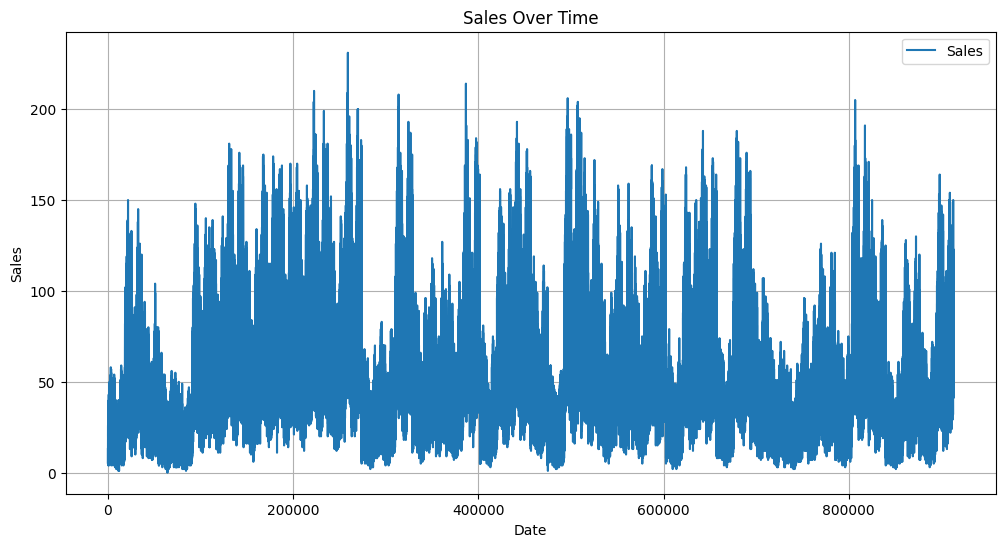

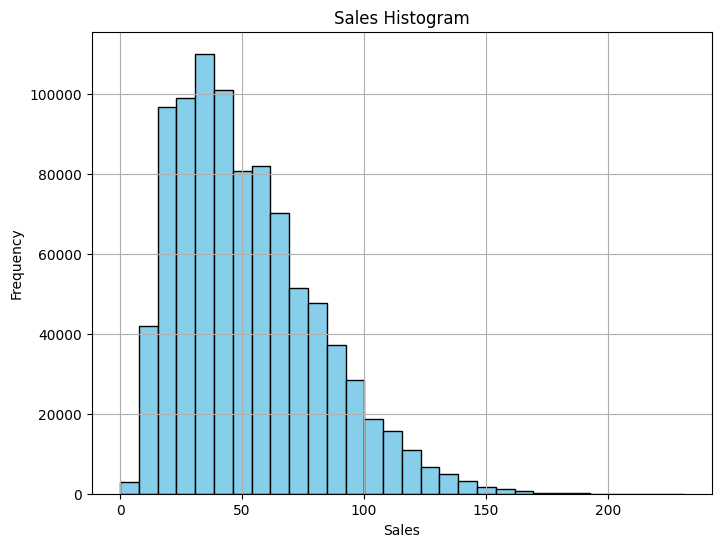

Summary Statistics for Sales:
count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64


In [8]:
import pandas as pd
import matplotlib.pyplot as plt


# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(train['sales'], label='Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(train['sales'], bins=30, color='skyblue', edgecolor='black')
plt.title('Sales Histogram')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Summary Statistics
summary_stats = train['sales'].describe()
print("Summary Statistics for Sales:")
print(summary_stats)

In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [10]:
# For store = 1, item = 1
train_df = train[(train['store']==1) & (train['item']==1)]
# train_df.set_index('date')
train_df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
1821,2017-12-27,1,1,14
1822,2017-12-28,1,1,19
1823,2017-12-29,1,1,15
1824,2017-12-30,1,1,27


<Figure size 640x480 with 0 Axes>

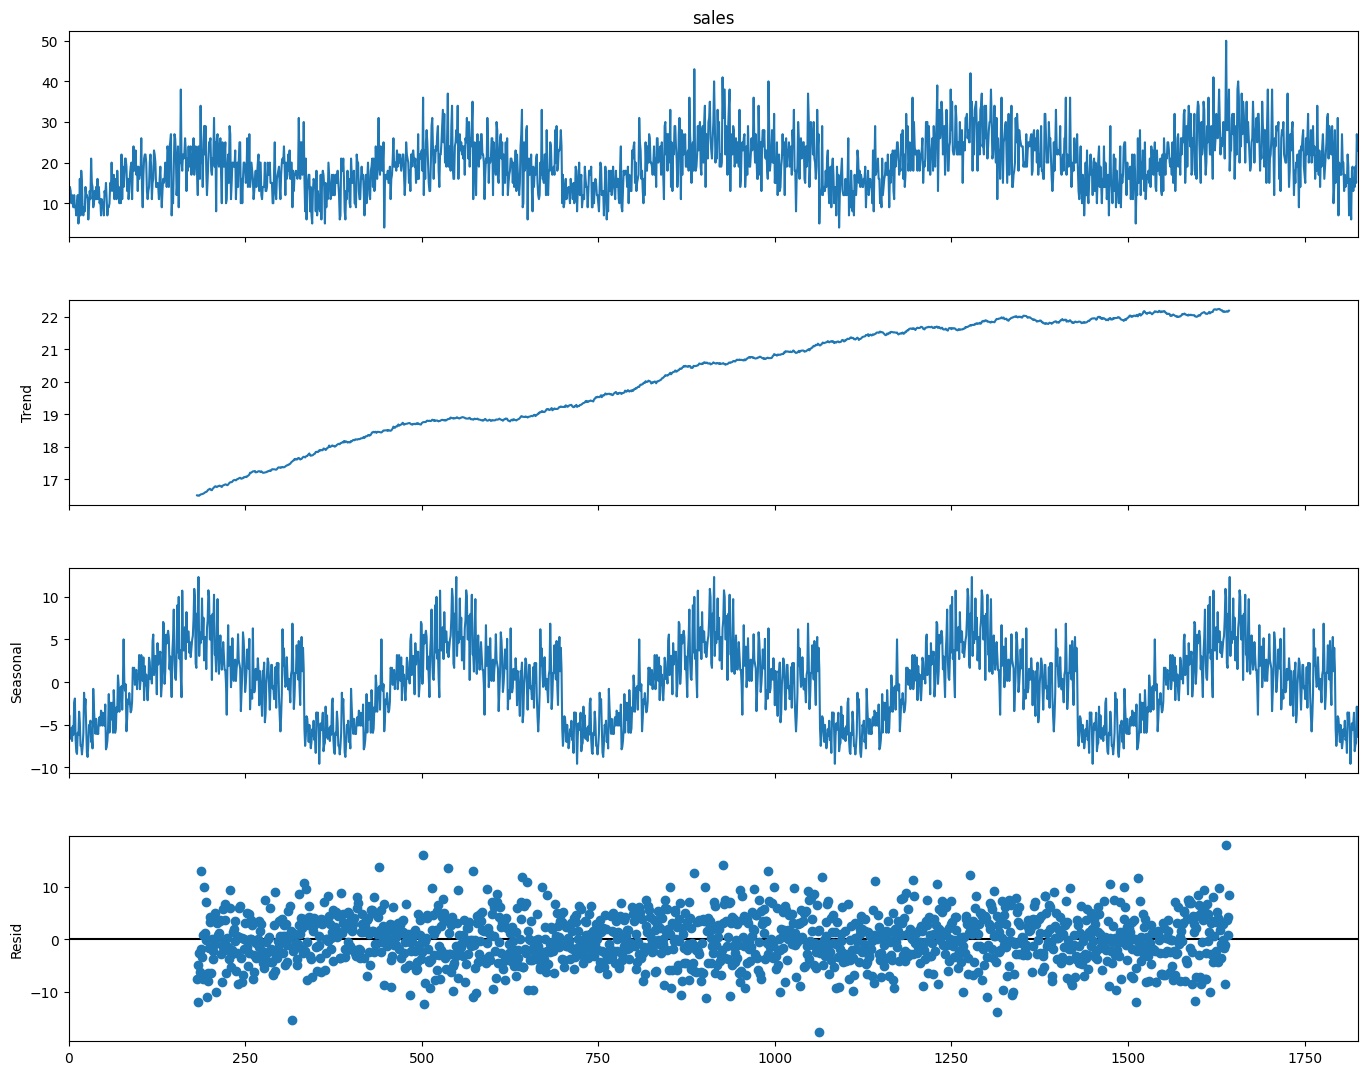

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', period=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [12]:
# Run Dicky-Fuller test to check for stationarity
result = adfuller(train_df['sales'])
print('The test statistics:', result[0])
print('The p-value:', result[1])

The test statistics: -3.157670556332808
The p-value: 0.022569380626571284


In [13]:
train_df['sales'].diff().dropna()

1       -2.0
2        3.0
3       -1.0
4       -3.0
5        2.0
        ... 
1821    -2.0
1822     5.0
1823    -4.0
1824    12.0
1825    -4.0
Name: sales, Length: 1825, dtype: float64

In [14]:
#we check again how stationary our data is
result = adfuller(train_df['sales'].diff().dropna())
print('The test statistics:', result[0])
print('The p-value:', result[1])

The test statistics: -12.676793886047463
The p-value: 1.2109276320437597e-23


<Axes: >

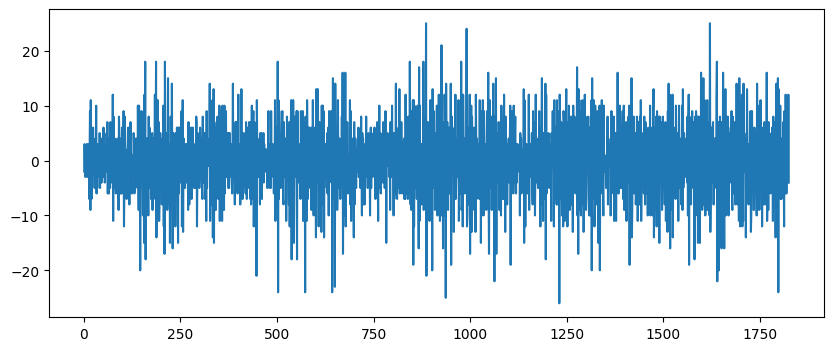

In [15]:
train_df['sales'].diff().dropna().plot(figsize=(10,4))

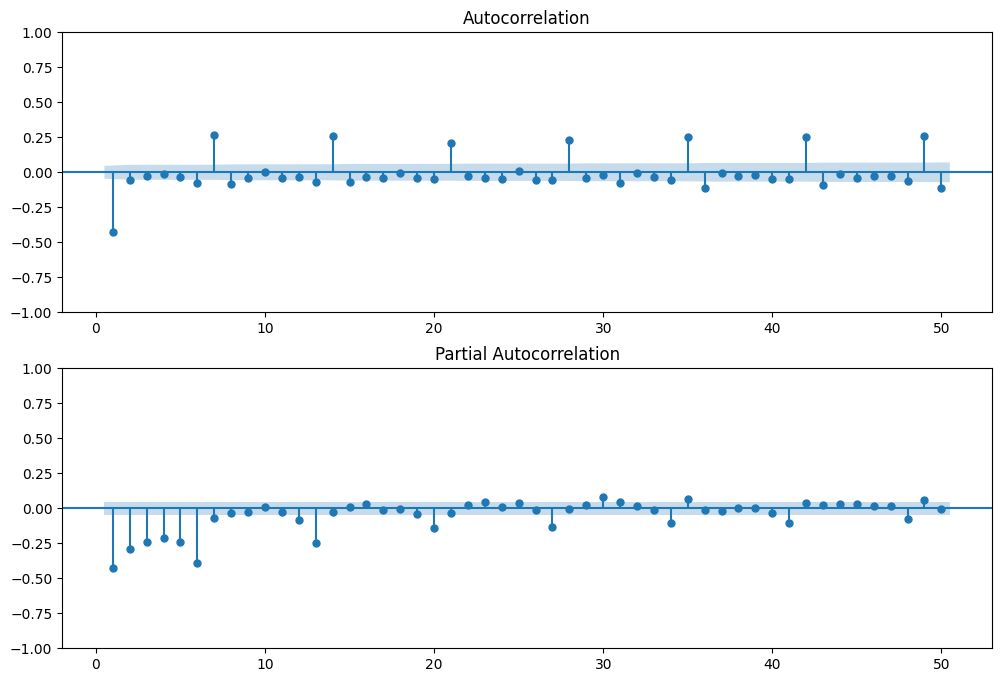

In [16]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot Autocorrelation function (ACF) - used to find q parameter
plot_acf(train_df['sales'].diff().dropna(), lags=50, zero=False, ax=ax1)

# Partial Autocorrelation function (PACF) - used to find p parameter
plot_pacf(train_df['sales'].diff().dropna(), lags=50, zero=False, ax=ax2)

plt.show()

In [17]:
import warnings
warnings.simplefilter('ignore')

In [18]:
order_aic_bic = []

# Loop over p values from 0-10
for p in range(10):
    print('p:', p)

    # Loop over q values from 0-10
    for q in range(10):

        try:
            # create and fit ARMA(p,q) model
            model = sm.tsa.ARIMA(train_df.sales, order=(p, 1, q))
            results = model.fit()

            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)

# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

p: 0
p: 1
1 7 None None
1 8 None None
1 9 None None
p: 2
p: 3
3 7 None None
3 8 None None
3 9 None None
p: 4
4 0 None None
4 4 None None
4 5 None None
4 6 None None
p: 5
5 7 None None
p: 6
p: 7
p: 8
p: 9


In [19]:
order_df.sort_values(by='aic', ascending=True).head()

,p,q,aic,bic
87,9,8,10884.621627,10983.789662
67,7,8,10889.838429,10977.987793
88,9,9,10903.437988,11008.115358
77,8,8,10905.812998,10999.471698
56,6,7,10905.884532,10983.015226


In [20]:
order_df.sort_values(by='bic', ascending=True).head()

,p,q,aic,bic
67,7,8,10889.838429,10977.987793
56,6,7,10905.884532,10983.015226
87,9,8,10884.621627,10983.789662
58,6,9,10910.544945,10998.694309
66,7,7,10916.651967,10999.291996


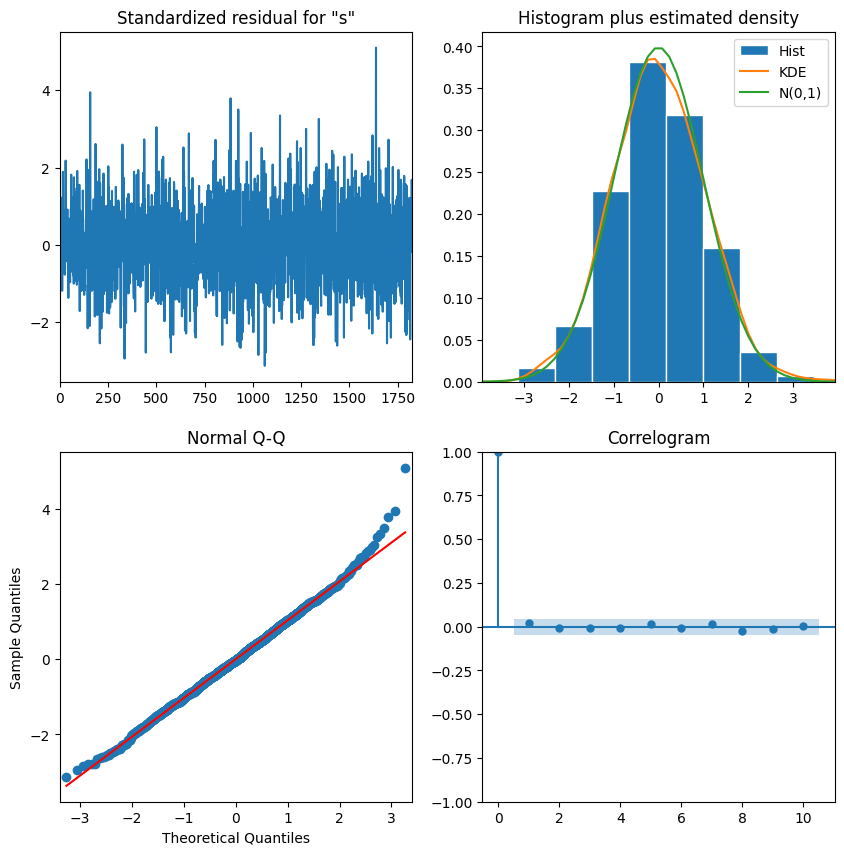

In [21]:
# Create and fit model
arima_model = sm.tsa.ARIMA(train_df.sales, order=(9,1,8)).fit()

# Create the 4 diagostics plots
arima_model.plot_diagnostics(figsize=(10,10))
plt.show()

In [22]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(9, 1, 8)   Log Likelihood               -5424.311
Date:                Thu, 16 Nov 2023   AIC                          10884.622
Time:                        10:59:56   BIC                          10983.790
Sample:                             0   HQIC                         10921.203
                               - 1826                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0969      0.124     -0.784      0.433      -0.339       0.145
ar.L2         -0.1117      0.127     -0.877      0.380      -0.361       0.138
ar.L3         -0.1035      0.139     -0.744      0.4

<Axes: >

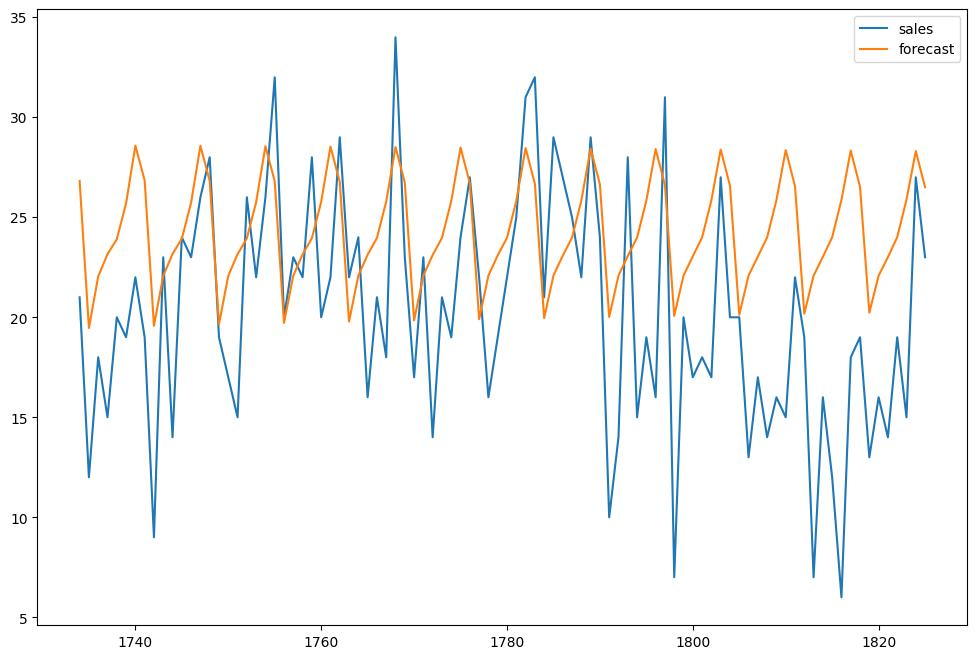

In [23]:
index_1 = 1734
index_2 = 1826
train_df['forecast'] = arima_model.predict(start=index_1, end=index_2, dynamic= True)
train_df[index_1:index_2][['sales', 'forecast']].plot(figsize=(12, 8))

In [24]:
def SMAPE(actual, forecast):
    smape = np.mean(np.abs(forecast - actual) / ((np.abs(forecast) + np.abs(actual))/2)) * 100
    print('SMAPE: ', smape)

SMAPE(train_df[1734:1826]['sales'], train_df[1734:1826]['forecast'])

SMAPE:  26.807766265186718


In [25]:
train_df

,date,store,item,sales,forecast
0,2013-01-01,1,1,13,NaN
1,2013-01-02,1,1,11,NaN
2,2013-01-03,1,1,14,NaN
3,2013-01-04,1,1,13,NaN
4,2013-01-05,1,1,10,NaN
...,...,...,...,...,...
1821,2017-12-27,1,1,14,23.008824
1822,2017-12-28,1,1,19,24.003902
1823,2017-12-29,1,1,15,25.878440
1824,2017-12-30,1,1,27,28.309781


In [26]:
import pandas as pd

# Sample data loading step (replace this with your actual data loading)
# train = pd.read_csv('your_data.csv')

# Dates for training and validation
train_start_date = '2013-01-01'
train_end_date = '2017-09-30'
pred_start_date = '2017-01-10'
pred_end_date = '2017-12-31'

# Ensure the 'date' column is in DateTime format
train['date'] = pd.to_datetime(train['date'])

# Set the 'date' column as the index
train.set_index('date', inplace=True)

# Filter the DataFrame for the specified date range
y_val = train.loc[pred_start_date:pred_end_date]

# Add a 'forecast' column initialized with NaN values
y_val['forecast'] = np.nan

# Display the resulting DataFrame
y_val


,store,item,sales,forecast
date,,,,
2017-01-10,1,1,11,NaN
2017-01-11,1,1,14,NaN
2017-01-12,1,1,17,NaN
2017-01-13,1,1,7,NaN
2017-01-14,1,1,16,NaN
...,...,...,...,...
2017-12-27,10,50,63,NaN
2017-12-28,10,50,59,NaN
2017-12-29,10,50,74,NaN


In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time

# Assuming 'train' is your DataFrame containing the data

# Define the SMAPE function
def SMAPE(true, forecasted):
    denominator = (np.abs(true) + np.abs(forecasted)) / 2.0
    diff = np.abs(true - forecasted) / denominator
    valid_mask = ~np.isnan(diff)
    return np.mean(diff[valid_mask]) * 100 if valid_mask.any() else np.nan

# Define prediction start and end dates
pred_start_date = '2017-10-01'
pred_end_date = '2017-12-31'

# Filtering the validation data
y_val = train.loc[pred_start_date:pred_end_date]

# Initialize a dictionary for average sMAPE values per store
average_smape_per_store = {}

# Iterate over stores
for store in train['store'].unique():
    print(f"Processing Store {store}")
    train_store = train[train['store'] == store]
    smape_values = []

    # Iterating over item pairs in the current store
    for item in train_store['item'].unique():
        start_time = time.time()  # Start time

        # Filter training data for current item in the store
        train_subset = train_store[(train_store['item'] == item) & (train_store.index <= train_end_date)]
        y_train = train_subset['sales']

        # Model Training
        model = sm.tsa.ARIMA(y_train, order=(9, 1, 8))  # Adjust order as needed
        results = model.fit()

        # Forecasting
        y_val_subset = y_val[(y_val['store'] == store) & (y_val['item'] == item)]
        y_val_subset['forecast'] = results.predict(start=pd.Timestamp(pred_start_date), end=pd.Timestamp(pred_end_date), dynamic=True)

        # Calculate and append sMAPE
        smape = SMAPE(y_val_subset['sales'], y_val_subset['forecast'])
        if not np.isnan(smape):
            smape_values.append(smape)

        end_time = time.time()  # End time
        processing_time = end_time - start_time  # Calculate processing time
        print(f"Processing time for item {item} in Store {store}: {processing_time:.2f} seconds")

    # Calculate the average sMAPE for the store
    average_smape = np.mean(smape_values)
    average_smape_per_store[store] = average_smape
    print(f"Average sMAPE for Store {store}: {average_smape:.2f}")

# Display average sMAPE per store
for store, smape in average_smape_per_store.items():
    print(f"Store {store}: Average sMAPE = {smape:.2f}")



Processing time for item 1 in Store 1: 7.65 seconds
Processing time for item 2 in Store 1: 9.55 seconds
Processing time for item 3 in Store 1: 8.89 seconds
Processing time for item 4 in Store 1: 10.44 seconds
Processing time for item 5 in Store 1: 9.04 seconds
Processing time for item 6 in Store 1: 12.11 seconds
Processing time for item 7 in Store 1: 10.99 seconds
Processing time for item 8 in Store 1: 7.99 seconds
Processing time for item 9 in Store 1: 10.73 seconds
Processing time for item 10 in Store 1: 9.04 seconds
Processing time for item 11 in Store 1: 8.79 seconds
Processing time for item 12 in Store 1: 8.45 seconds
Processing time for item 13 in Store 1: 11.44 seconds
Processing time for item 14 in Store 1: 9.88 seconds
Processing time for item 15 in Store 1: 8.91 seconds
Processing time for item 16 in Store 1: 10.36 seconds
Processing time for item 17 in Store 1: 8.44 seconds
Processing time for item 18 in Store 1: 13.44 seconds
Processing time for item 19 in Store 1: 8.90 sec

In [33]:
# Load test data
testcsv_path= "/kaggle/input/demand-forecasting-kernels-only/test.csv"


In [34]:
test = pd.read_csv(testcsv_path)


# Ensure the 'date' column is in DateTime format
test['date'] = pd.to_datetime(test['date'])

# Set the 'date' column as the index
test.set_index('date', inplace=True)
test.head()


,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [38]:
predictions = []
for store in test['store'].unique():
    test_store = test[test['store'] == store]

    for item in test_store['item'].unique():
        # Filter test data for the current item in the store
        test_subset = test_store[test_store['item'] == item]

        # Assuming you're using the same model as trained before
        # Forecasting
        start_forecast_date = test_subset.index.min()  # Adjust as needed
        end_forecast_date = test_subset.index.max()  # Adjust as needed
        forecast = results.predict(start=start_forecast_date, end=end_forecast_date, dynamic=True)

        # Append forecast to predictions
        predictions.extend(forecast)


In [43]:
# Assuming 'test' is your test DataFrame and 'predictions' is a list of predicted values
submission = pd.DataFrame({
    'id': test['id'],  # or the appropriate column that serves as an identifier
    'prediction': predictions
})
submission.head()

,id,prediction
date,,
2018-01-01,0,63.388007
2018-01-02,1,66.134389
2018-01-03,2,67.823314
2018-01-04,3,70.249626
2018-01-05,4,76.933748


In [45]:
submission.to_csv('submission.csv', index=False)
